In [2]:
import streamlit as st
import pandas as pd
import numpy as np
import yaml
import pyodbc
from market_growth_analysis.etl.stagging import *
import pandas as pd
import numpy as np
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine
import sys
import pandas as pd
import matplotlib.pyplot as plt

# sys.path.append('../conf') 
# Load the YAML file
with open('../../conf/global.yml', 'r') as f:
    columns = yaml.safe_load(f)

# Load the YAML file
with open('../../conf/local.yml', 'r') as f:
    credentials = yaml.safe_load(f)


# Get credentials
driver = credentials['warehouse_db']['driver']
server = credentials['warehouse_db']['server']
database = credentials['warehouse_db']['database']
trusted = credentials['warehouse_db']['trusted_connection']
user = credentials['warehouse_db']['user']
password = credentials['warehouse_db']['password']

# Create connection db
conn = pyodbc.connect('Driver={SQL Server};'
                      f'Server={server};'
                      f'Database={database};'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

In [3]:
# Get data
join_tables_query = '''
select *
from DIM_COMPANY dim
join FACT_BALANCE_SHEET bs on bs.ticker = dim.ticker
join FACT_CASH_FLOW_STATEMENT cfs on cfs.PK = bs.PK
join FACT_INCOME_STATEMENT fis on fis.PK = bs.PK
join FACT_PRICES fp on fp.PK = bs.PK
join FACT_RATIOS fr on fr.PK = bs.PK
'''
data = pd.read_sql(join_tables_query, conn)
# drop duplicated columns
data = data.T.drop_duplicates().T
data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d").dt.strftime("%Y/%m/%d")


C:\Users\germa\AppData\Local\Temp/ipykernel_11388/764186177.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(join_tables_query, conn)


In [4]:
data.columns

Index(['ticker', 'company_full_name', 'country', 'industry', 'sector', 'PK',
       'Date', 'Cash On Hand', 'Receivables', 'Inventory', 'Pre-Paid Expenses',
       'Other Current Assets', 'Total Current Assets',
       'Property, Plant, And Equipment', 'Long-Term Investments',
       'Goodwill And Intangible Assets', 'Other Long-Term Assets',
       'Total Long-Term Assets', 'Total Assets', 'Total Current Liabilities',
       'Long Term Debt', 'Other Non-Current Liabilities',
       'Total Long Term Liabilities', 'Total Liabilities', 'Common Stock Net',
       'Retained Earnings (Accumulated Deficit)', 'Comprehensive Income',
       'Other Share Holders Equity', 'Share Holder Equity',
       'Total Liabilities And Share Holders Equity', 'Net Income/Loss',
       'Total Depreciation And Amortization - Cash Flow',
       'Other Non-Cash Items', 'Total Non-Cash Items',
       'Change In Accounts Receivable', 'Change In Inventories',
       'Change In Accounts Payable', 'Change In Assets/L

In [5]:
data['country'].value_counts()

United States           39989
Canada                   1557
China                    1229
Israel                    753
United Kingdom            709
Bermuda                   443
Ireland                   354
Brazil                    350
Netherlands               194
Hong Kong, SAR China      193
Switzerland               189
Greece                    189
Argentina                 178
Germany                   150
South Korea               142
Mexico                    142
Japan                     129
Singapore                 127
India                     123
Australia                 119
Luxembourg                117
Taiwan                    117
France                    115
South Africa               94
Cayman Islands             94
Chile                      86
Colombia                   60
Spain                      56
Belgium                    54
Sweden                     53
Peru                       53
Denmark                    45
Italy                      42
Panama    

In [6]:
data['industry'].value_counts()

Medical - Biomedical and Genetics        3573
Medical - Drug Manufacturing             1682
Technology Services                      1232
Banks - Northeast                        1199
REIT - Other Equity Trusts               1165
                                         ... 
Nanotechnology Equipment and Services      11
Electronics - Military Systems             11
Retail - Mail Order & Direct                9
Printing & Trade Machinery                  8
Periodical Publishing                       2
Name: industry, Length: 252, dtype: int64

In [7]:
columns_to_study = columns['columns_prices'] + columns['columns_ratios'] + columns['column_id']

In [258]:
industry = 'Technology Services'
industry = 'Medical - Drug Manufacturing'

data_filtered_industry = data[(data['industry'] == industry)&(data['country'] == 'United States')]

In [259]:
len(data_filtered_industry['ticker'].unique())

176

In [260]:
data_to_study = data_filtered_industry[columns_to_study]

In [261]:
data_to_study = data_to_study.dropna(subset='Growth +5')

In [262]:
data_to_study_filled = data_to_study.fillna(value=0)

In [263]:
data_to_study_filled.columns

Index(['longevity', 'Close', 'Volume', 'Growth -1', 'Growth +1', 'Growth +5',
       'Growth -10', 'Growth -5', 'Enterprise Value (EV)', 'EV / Revenue',
       'EV / EBITDA', 'EV / EBIT', 'EV / Invested Capital',
       'Free Cash Flow (FCF)', 'EV / Free Cash Flow', 'P/E', 'P/S', 'P/CF',
       'PK', 'ticker', 'Date'],
      dtype='object')

In [264]:
columns_to_drop = ['Growth +1', 
                #    'Date', 
                #    'ticker', 
                   'Close', 
                   'Volume', 
                   'longevity', 
                   'Enterprise Value (EV)', 
                   'Free Cash Flow (FCF)', 
                   'EV / EBITDA', 
                   'Growth -5', 
                   'Growth -1', 
                   'Growth -10',
                   'EV / Free Cash Flow',
                   'EV / Invested Capital'
                   ]
data_to_study_filled_drop = data_to_study_filled.drop(columns=columns_to_drop)
data_to_study_filled_drop = data_to_study_filled_drop.set_index(keys='PK')

In [265]:
data_to_study_filled_drop['Growth +5']*100

PK
10648   -18.604652
10308   -27.163634
10309    19.974314
10310    25.677150
10650    -1.538466
           ...    
13155   -99.894366
39957   -94.339623
13340   -35.942028
11993   -61.994078
39960   -76.103898
Name: Growth +5, Length: 668, dtype: float64

In [266]:
(data_to_study_filled_drop['Growth +5']*100).describe()

count     668.000000
mean       21.576785
std       202.832866
min       -99.996467
25%       -89.907407
50%       -47.014683
75%        51.772488
max      2442.608728
Name: Growth +5, dtype: float64

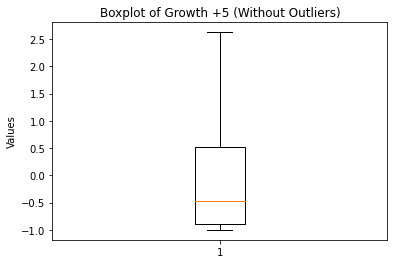

In [267]:
import matplotlib.pyplot as plt

# Assuming data_to_study_filled_drop is your DataFrame
plt.boxplot(data_to_study_filled_drop['Growth +5'], showfliers=False)
plt.title('Boxplot of Growth +5 (Without Outliers)')
plt.ylabel('Values')
plt.show()


In [268]:
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['Growth +5'] > 0
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['target'].astype(int)

import pandas as pd
import numpy as np

# Assuming you have a DataFrame named data_to_study_final
# data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
#                         np.where(data_to_study_filled_drop['Growth +5'] <= data_to_study_filled_drop['Growth +5'].quantile(0.9), 1, 2))

data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 1)

# data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
#                                     np.where(data_to_study_filled_drop['Growth +5'] < 2.5, 1, 2))

num_classes = len(data_to_study_filled_drop['target'].unique())
num_classes

2

In [269]:
data_to_study_filled_drop['target'].value_counts()

0    433
1    235
Name: target, dtype: int64

In [270]:
data_to_study_filled_drop['Growth +5'].quantile(0.9)

2.0418973750800165

In [271]:
# data_to_study_final = data_to_study_filled_drop.drop(columns='Growth +5')
data_to_study_final = data_to_study_filled_drop

In [272]:
data_to_study_final.shape

(668, 9)

In [273]:
data_to_study_final['target'].value_counts()

0    433
1    235
Name: target, dtype: int64

# Create LSTM Model

In [274]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [275]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Prepare Data

In [276]:
# Load your financial data into a DataFrame (replace 'your_data.csv' with your dataset)
df = data_to_study_final.copy()

# Define the sequence length and other hyperparameters
n_steps = 4  # years to study prior
num_companies = len(df['ticker'].unique())  # Assuming you have a 'ticker' column

# Use LabelEncoder to convert 'ticker' values to numerical labels
label_encoder = LabelEncoder()
df['ticker'] = label_encoder.fit_transform(df['ticker'])

# Split the data into train and test based on the 'Date' column
df['Date'] = pd.to_datetime(df['Date'])
train_data = df[df['Date'].dt.year < 2013]
test_data = df[df['Date'].dt.year >= 2013]

# Prepare an empty list to store sequences for all companies
all_sequences_train = []
all_targets_train = []  # To store the corresponding target values
all_info_rows_train = []
all_sequences_test = []
all_targets_test = []  # To store the corresponding target values
all_info_rows_test = []

# # Iterate through unique company labels in the train set
# for label in train_data['ticker'].unique():
#     # Filter data for the current company label
#     company_data = train_data[train_data['ticker'] == label]

#     # Sort data by date
#     company_data_complete = company_data.sort_values(by='Date')
#     company_data = company_data.sort_values(by='Date').drop(columns=['Date', 'ticker', 'Growth +5'])
#     n_features = len(company_data.columns)

#     # Create sequences for the current company in the train set
#     sequences_train = []
#     targets_train = []  # To store the corresponding target values
#     info_rows_train = []

#     for i in range(len(company_data) - n_steps + 1):
#         sequence = company_data.iloc[i:i + n_steps, 0:n_features].values
#         target = company_data.iloc[i + n_steps - 1, n_features - 1]  # Assuming the target column is the last one
#         info_row = company_data_complete.iloc[i + n_steps - 1]
#         sequences_train.append(sequence)
#         targets_train.append(target)
#         info_rows_train.append(info_row)

#     # Append sequences and corresponding targets to the train lists
#     all_sequences_train.extend(sequences_train)
#     all_targets_train.extend(targets_train)
#     all_info_rows_train.extend(info_rows_train)

# # Iterate through unique company labels in the test set
# for label in test_data['ticker'].unique():
#     # Filter data for the current company label in the test set
#     company_data = test_data[test_data['ticker'] == label]

#     # Sort data by date
#     company_data_complete = company_data.sort_values(by='Date')
#     company_data = company_data.sort_values(by='Date').drop(columns=['Date', 'ticker', 'Growth +5'])
#     n_features = len(company_data.columns)

#     # Create sequences for the current company in the test set
#     sequences_test = []
#     targets_test = []  # To store the corresponding target values
#     info_rows_test = []

#     for i in range(len(company_data) - n_steps + 1):
#         sequence = company_data.iloc[i:i + n_steps, 0:n_features].values
#         target = company_data.iloc[i + n_steps - 1, n_features - 1]  # Assuming the target column is the last one
#         info_row = company_data_complete.iloc[i + n_steps - 1]
#         sequences_test.append(sequence)
#         targets_test.append(target)
#         info_rows_test.append(info_row)

#     # Append sequences and corresponding targets to the test lists
#     all_sequences_test.extend(sequences_test)
#     all_targets_test.extend(targets_test)
#     all_info_rows_test.extend(info_rows_test)


In [277]:
def generate_sequences_targets(data, n_steps):
    all_sequences = []
    all_targets = []
    all_info_rows = []

    for label in data['ticker'].unique():
        company_data = data[data['ticker'] == label]

        company_data_complete = company_data.sort_values(by='Date')
        company_data = company_data.sort_values(by='Date').drop(columns=['Date', 'ticker', 'Growth +5'])
        n_features = len(company_data.columns)

        sequences = []
        targets = []
        info_rows = []

        for i in range(len(company_data) - n_steps + 1):
            sequence = company_data.iloc[i:i + n_steps, 0:n_features].values
            target = company_data.iloc[i + n_steps - 1, n_features - 1]  # Assuming the target column is the last one
            info_row = company_data_complete.iloc[i + n_steps - 1]

            sequences.append(sequence)
            targets.append(target)
            info_rows.append(info_row)

        all_sequences.extend(sequences)
        all_targets.extend(targets)
        all_info_rows.extend(info_rows)

    return all_sequences, all_targets, all_info_rows

# # Split the data into train and test based on the 'Date' column
# train_data = df[df['Date'].dt.year < 2013]
# test_data = df[df['Date'].dt.year >= 2013]

# Generate sequences and targets for train and test sets
all_sequences_train, all_targets_train, all_info_rows_train = generate_sequences_targets(train_data, n_steps)
all_sequences_test, all_targets_test, all_info_rows_test = generate_sequences_targets(test_data, n_steps)


In [278]:
len(all_info_rows_train)

47

In [279]:
all_sequences_train

[array([[ 3.12675998e+01, -2.83339738e-01, -1.31249999e+00,
          2.71309741e+01, -1.23545006e+00,  1.00000000e+00],
        [ 2.70607366e+01, -3.28828094e+00, -4.50000004e+00,
          2.71309741e+01, -4.89545967e+00,  1.00000000e+00],
        [ 3.12675998e+01, -4.02634274e+00, -4.44827573e+00,
          2.71309741e+01, -5.62269191e+00,  0.00000000e+00],
        [ 3.12675998e+01,  6.81466963e-03, -3.14285713e+00,
          2.71309741e+01, -2.57071822e+00,  1.00000000e+00]]),
 array([[ 31.26759982,  -6.14042165,  -7.3157894 ,  27.13097406,
          -8.11395473,   1.        ],
        [ 31.26759982,  -8.85880209, -10.15789446,  27.13097406,
         -11.8365247 ,   1.        ],
        [ 31.26759982,  -7.74179718,  -8.76923096,  27.13097406,
         -10.39842286,   1.        ],
        [ 23.39535686,  -2.13300742,  -3.48780475,  27.13097406,
          -3.69271086,   1.        ]]),
 array([[ 4.60757472, 34.72654551, 79.94117737,  5.69167272, 47.60655387,
          0.        ],
   

In [280]:
all_info_rows_test

[Growth +5                  5.447619
 EV / Revenue                31.2676
 EV / EBIT                  -2.54203
 P/E                       -4.772727
 P/S                       27.130974
 P/CF                      -4.844198
 ticker                           24
 Date            2016-12-31 00:00:00
 target                            1
 Name: 10653, dtype: object,
 Growth +5                  3.757033
 EV / Revenue                31.2676
 EV / EBIT                -13.699224
 P/E                      -18.619048
 P/S                       27.130974
 P/CF                     -24.412107
 ticker                           24
 Date            2017-12-31 00:00:00
 target                            1
 Name: 10654, dtype: object,
 Growth +5                  1.727273
 EV / Revenue              10.071287
 EV / EBIT                 80.460474
 P/E                       81.139495
 P/S                       10.368406
 P/CF                      45.846836
 ticker                           21
 Date            

In [281]:
all_info_rows_train[0]

Growth +5                  7.886364
EV / Revenue                31.2676
EV / EBIT                  0.006815
P/E                       -3.142857
P/S                       27.130974
P/CF                      -2.570718
ticker                           24
Date            2012-12-31 00:00:00
target                            1
Name: 10649, dtype: object

In [282]:
n_steps

4

In [283]:
new_list = []
new_list.append([1,2,3])
new_list.append([2,3,4,3])
new_list[0]

[1, 2, 3]

In [284]:
len(all_sequences_train)

47

In [285]:
all_info_rows_train[0]

Growth +5                  7.886364
EV / Revenue                31.2676
EV / EBIT                  0.006815
P/E                       -3.142857
P/S                       27.130974
P/CF                      -2.570718
ticker                           24
Date            2012-12-31 00:00:00
target                            1
Name: 10649, dtype: object

In [286]:
all_sequences_train[0]

array([[ 3.12675998e+01, -2.83339738e-01, -1.31249999e+00,
         2.71309741e+01, -1.23545006e+00,  1.00000000e+00],
       [ 2.70607366e+01, -3.28828094e+00, -4.50000004e+00,
         2.71309741e+01, -4.89545967e+00,  1.00000000e+00],
       [ 3.12675998e+01, -4.02634274e+00, -4.44827573e+00,
         2.71309741e+01, -5.62269191e+00,  0.00000000e+00],
       [ 3.12675998e+01,  6.81466963e-03, -3.14285713e+00,
         2.71309741e+01, -2.57071822e+00,  1.00000000e+00]])

In [287]:
all_targets_train[0]

1

# Split train test

In [288]:
# from sklearn.model_selection import train_test_split

# # Define the percentage of data to allocate for testing
# test_size = 0.2

# # Calculate the index to split the data
# split_index = int(len(all_targets) * (1 - test_size))

# Split the data into training and testing sets
X_train, X_test = all_sequences_train, all_sequences_test
y_train, y_test = all_targets_train, all_targets_test

train_all_info, test_all_info = all_info_rows_train, all_info_rows_test

## Create Model

In [289]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the LSTM model for classification
class LSTMClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

# hyperparameters

In [290]:
# Define hyperparameters
input_size = len(all_sequences_train[0][0])  # Number of features in each sequence
hidden_size = 16
num_layers = 1
output_size = num_classes  # Three classes for classification (0, 1, 2)

# Create the classification model
classification_model = LSTMClassificationModel(input_size, hidden_size, num_layers, output_size)

# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.int)

# Train

In [291]:
# Train the classification model
num_epochs = 200
best_precision = 0.0  # Initialize the best precision for class 1
best_model = None

for epoch in range(num_epochs):
    outputs = classification_model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Evaluate precision on class 1 (target = 1)
    classification_model.eval()
    with torch.no_grad():
        test_outputs = classification_model(X_test)

        # Apply softmax to obtain class probabilities
        class_probs = torch.nn.functional.softmax(test_outputs, dim=1)
        _, predicted = torch.max(test_outputs, 1)  # Get the predicted class labels

        # Convert the predictions and class probabilities to numpy arrays
        y_pred = predicted.cpu().numpy()
        class_probs = class_probs.cpu().numpy()

    # Calculate precision for class 1
    precision_class_1 = precision_score(y_test, y_pred, labels=[1], average='macro')

    # Check if precision for class 1 is better than the best seen so far
    if precision_class_1 > best_precision:
        best_precision = precision_class_1
        best_model = classification_model.state_dict()
        print(f'Improved precision for class 1: {best_precision:.4f}')

# Use the best model with the highest precision for class 1
classification_model.load_state_dict(best_model)

Improved precision for class 1: 0.3205
Improved precision for class 1: 0.3333
Improved precision for class 1: 0.3462
Improved precision for class 1: 0.3553
Improved precision for class 1: 0.3649
Improved precision for class 1: 0.3714
Improved precision for class 1: 0.3889
Improved precision for class 1: 0.3913
Epoch [10/200], Loss: 0.6676
Improved precision for class 1: 0.4000
Improved precision for class 1: 0.4062
Improved precision for class 1: 0.4286
Improved precision for class 1: 0.4333
Improved precision for class 1: 0.4340
Improved precision for class 1: 0.4510
Improved precision for class 1: 0.4583
Epoch [20/200], Loss: 0.6392
Epoch [30/200], Loss: 0.6168
Epoch [40/200], Loss: 0.5948
Epoch [50/200], Loss: 0.5733
Epoch [60/200], Loss: 0.5504
Epoch [70/200], Loss: 0.5270
Epoch [80/200], Loss: 0.5031
Improved precision for class 1: 0.4600
Improved precision for class 1: 0.4800
Epoch [90/200], Loss: 0.4782
Epoch [100/200], Loss: 0.4543
Improved precision for class 1: 0.4898
Improve

<All keys matched successfully>

# Evaluate

In [292]:
# Evaluate the classification model on the test data
classification_model.eval()
with torch.no_grad():
    test_outputs = classification_model(X_test)
    _, predicted = torch.max(test_outputs, 1)  # Get the predicted class labels

# Convert the predictions and true labels to numpy arrays
y_pred = predicted.cpu().numpy()
y_true = y_test.numpy()


In [293]:
# Filter class_probs for examples where y_pred is equal to 1
indices_class_1 = (y_pred == 1)  # Get indices where y_pred is equal to 1
class_probs_class_1 = class_probs[indices_class_1]  # Filter class_probs

# Create y_pred_mod based on class_probs_class_1
y_pred_mod = np.zeros_like(y_pred)
y_pred_mod[indices_class_1] = (class_probs_class_1[:, 1] > 0.9).astype(int)

In [294]:
(class_probs_class_1[:, 1] > 0.95)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [295]:
all_info_rows_test

[Growth +5                  5.447619
 EV / Revenue                31.2676
 EV / EBIT                  -2.54203
 P/E                       -4.772727
 P/S                       27.130974
 P/CF                      -4.844198
 ticker                           24
 Date            2016-12-31 00:00:00
 target                            1
 Name: 10653, dtype: object,
 Growth +5                  3.757033
 EV / Revenue                31.2676
 EV / EBIT                -13.699224
 P/E                      -18.619048
 P/S                       27.130974
 P/CF                     -24.412107
 ticker                           24
 Date            2017-12-31 00:00:00
 target                            1
 Name: 10654, dtype: object,
 Growth +5                  1.727273
 EV / Revenue              10.071287
 EV / EBIT                 80.460474
 P/E                       81.139495
 P/S                       10.368406
 P/CF                      45.846836
 ticker                           21
 Date            

# Metrics

In [296]:
def metrics_form(y_true, y_pred):    
    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print('Confusion Matrix:')
    print(confusion)

In [297]:
# Calculate classification metrics
metrics_form(y_true, y_pred)

Accuracy: 0.5973
Precision: 0.4194
Recall: 0.5200
F1-score: 0.4643
Confusion Matrix:
[[63 36]
 [24 26]]


In [298]:
# Calculate classification metrics
metrics_form(y_true, y_pred_mod)

Accuracy: 0.7114
Precision: 0.8182
Recall: 0.1800
F1-score: 0.2951
Confusion Matrix:
[[97  2]
 [41  9]]


In [299]:
# Calculate precision for class 1
precision_class_1 = precision_score(y_true, y_pred_mod, labels=[1])
precision_class_1

0.8181818181818182

In [300]:
# Calculate precision for class 1
precision_class_1 = precision_score(y_true, y_pred, labels=[1])
precision_class_1

0.41935483870967744

In [301]:
# Calculate precision for class 1
recall_class_1 = recall_score(y_true, y_pred_mod, labels=[1])
recall_class_1

0.18

In [302]:
# Calculate precision for class 1
recall_class_1 = recall_score(y_true, y_pred, labels=[1])
recall_class_1

0.52

In [303]:
# Use list comprehension to select items
class_one_predited_info = [item for item, select in zip(test_all_info, y_pred_mod==1) if select]

growth_list = []

for info in class_one_predited_info:
    growth_list.append(info.to_list())

test_info_df =  pd.DataFrame(growth_list, columns=info.index)
test_info_df

,Growth +5,EV / Revenue,EV / EBIT,P/E,P/S,P/CF,ticker,Date,target
0,1.727273,10.071287,80.460474,81.139495,10.368406,45.846836,21,2016-12-31,1
1,0.124585,13.753468,41.425898,17.365384,14.125168,36.903928,21,2017-12-31,1
2,-0.249105,12.208799,81.077526,81.139495,12.335644,36.421279,44,2017-12-31,0
3,0.524457,0.648144,6.038394,7.666667,0.641996,7.896246,61,2016-06-30,1
4,0.233333,0.952494,32.368961,81.139495,0.837850,47.606554,62,2016-12-31,1
5,0.524316,10.091281,24.980733,24.598131,10.233705,11.714636,109,2016-12-31,1
6,0.506519,3.837893,5.779433,9.405245,4.198476,10.429651,104,2016-12-31,1
7,0.653595,1.493373,10.838521,15.338346,1.523608,11.197788,103,2016-12-31,1
8,-0.281567,1.660091,13.120777,29.268776,1.747053,14.782002,103,2017-12-31,0
9,3.558752,6.565668,23.022226,32.442424,5.456216,37.405307,110,2016-12-31,1


In [304]:
len(test_info_df) * 100

1100